### Importing libraries

In [13]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

import glob as glob
import random
import os
%matplotlib inline

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.15.0


### Preparing Data for Training

In [14]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.5, 1.5],)
train_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/train",
                                                    target_size=(img_size, img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/test",
                                                         target_size=(img_size, img_size),
                                                         color_mode="grayscale",
                                                         batch_size=batch_size,
                                                         class_mode="categorical",
                                                         shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Defining Model

In [15]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    return x

In [16]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [17]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3, 3))
    conv_2 = Convolution(conv_1, 64, (5, 5))
    conv_3 = Convolution(conv_2, 128, (3, 3))
    conv_4 = Convolution(conv_3, 512, (3, 3))

    flatten = Flatten()(conv_4)

    dense_1 = Dense_f(flatten, 256)
    dense_2 = Dense_f(dense_1,512)

    output = Dense(7, activation="softmax")(dense_2)
    model = Model(inputs=[inputs], outputs=[output])
    
    model.compile(loss=['categorical_crossentropy'], optimizer= 'Adam', metrics=['accuracy'])

    return model

In [18]:
model = model_fer((48, 48, 1))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 32)        0   

### Initializing the Model

In [19]:
epochs = 20
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights_RTED1.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]

### Training the Model

In [20]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/20


2024-03-03 10:44:24.318030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - ETA: 0s - loss: 1.9317 - accuracy: 0.2164
Epoch 1: saving model to model_weights_RTED1.h5
448/448 [==============================] - 59s 123ms/step - loss: 1.9317 - accuracy: 0.2164 - val_loss: 1.8199 - val_accuracy: 0.2259
Epoch 2/20
448/448 [==============================] - ETA: 0s - loss: 1.8505 - accuracy: 0.2328
Epoch 2: saving model to model_weights_RTED1.h5
448/448 [==============================] - 58s 129ms/step - loss: 1.8505 - accuracy: 0.2328 - val_loss: 1.7917 - val_accuracy: 0.2468
Epoch 3/20
448/448 [==============================] - ETA: 0s - loss: 1.8162 - accuracy: 0.2494
Epoch 3: saving model to model_weights_RTED1.h5
448/448 [==============================] - 59s 131ms/step - loss: 1.8162 - accuracy: 0.2494 - val_loss: 1.7976 - val_accuracy: 0.2681
Epoch 4/20
448/448 [==============================] - ETA: 0s - loss: 1.7651 - accuracy: 0.2763
Epoch 4: saving model to model_weights_RTED1.h5
448/448 [========================

### Model Evaluation

In [21]:
model.evaluate(validation_generator)

113/113 [==============================] - 12s 103ms/step - loss: 1.2414 - accuracy: 0.5224


[1.241434097290039, 0.5224296450614929]

### Plotting Loss

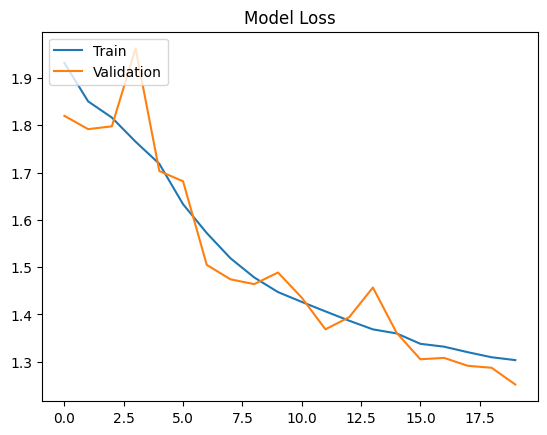

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Plotting Accuracy

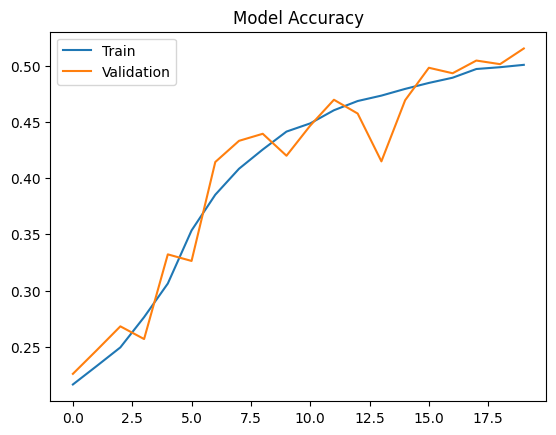

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Saving Model

In [24]:
model_json = model.to_json()
with open("model_RTED1.json", "w") as json_file:
    json_file.write(model_json)